### AutoML test 02: using Optuna library on my GraphAutoencoder model with 2 LAYERS

Output: 

 - For dynamic: **node_embeddings_D_AutoML-2relu**
 
 - For static: **node_embeddings_S_AutoML-2relu.csv**

In [ ]:
# !pip install fastdtw
# !pip install plotly

## Graph Auto Encoder

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.nn import GATConv
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
import os
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data


torch.backends.cudnn.benchmark = True  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ----- Models -----
class GATEncoder(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, out_dim, activation="relu"): 
        super(GATEncoder, self).__init__() 
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        
        if activation.lower() == "prelu":
            self.prelu = nn.PReLU()
            self.activation = self.prelu
        else:
            self.activation = self._get_activation(activation)
        
    def _get_activation(self, name):
        activations = {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, negative_slope=0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x
        }
        return activations.get(name.lower(), F.relu)
    
    def forward(self, x, edge_index):
        x = self.activation(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GATDecoder(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, activation="relu"):
        super(GATDecoder, self).__init__() 
        self.deconv1 = SAGEConv(in_features, hidden_dim)
        self.deconv2 = SAGEConv(hidden_dim, out_features)
        
        if activation.lower() == "prelu":
            self.prelu = nn.PReLU()
            self.activation = self.prelu
        else:
            self.activation = self._get_activation(activation)
        
    def _get_activation(self, name):
        activations = {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, negative_slope=0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x
        }
        return activations.get(name.lower(), F.relu)
        
    def forward(self, x, edge_index):
        #print(len(edge_index[0]))
        x = self.activation(self.deconv1(x, edge_index))
        x = self.deconv2(x, edge_index)
        return x


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# ====== CONFIGURATION ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# ========== Encoder ==========
class GSAGEVectorAttnEncoder(nn.Module): 
    def __init__(self, dynamic_dim, static_dim, hidden_dim, latent_dim, activation="relu", dropout_static=0.7): 
        super().__init__()
        self.dynamic_dim = dynamic_dim
        self.static_dim = static_dim
        self.input_dim = dynamic_dim + static_dim
        self.dropout_static = dropout_static

        # Vector-level attention gate (sigmoid gating)
        self.attn_gate = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim),
            nn.Sigmoid()
        )

        self.conv1 = SAGEConv(self.input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, latent_dim)
        self.activation = self._get_activation(activation)

    def _get_activation(self, name):
        return {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, 0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x
        }.get(name.lower(), F.relu)

    def forward(self, x, edge_index, return_attention=False):
        x_dyn = x[:, :self.dynamic_dim]
        x_stat = x[:, self.dynamic_dim:]

        # Apply dropout to static (optional)
#         if self.training and self.dropout_static > 0:
        x_stat = F.dropout(x_stat, p=self.dropout_static)

        # Vector-level attention gate
        x_cat = torch.cat([x_dyn, x_stat], dim=1)
        gate = self.attn_gate(x_cat)  # shape [N, input_dim]

        # Split gate for dynamic/static
        g_dyn = gate[:, :self.dynamic_dim]
        g_stat = gate[:, self.dynamic_dim:]

        # Apply attention
        x_attn = torch.cat([g_dyn * x_dyn, g_stat * x_stat], dim=1)

        # GCN Layers
        x = self.activation(self.conv1(x_attn, edge_index))
        x = self.conv2(x, edge_index)

#         if return_attention:
        return x, g_dyn, g_stat
#         return x


# ========== Decoder ==========
class GSAGEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, activation="relu"):
        super().__init__()
        self.deconv1 = SAGEConv(latent_dim, hidden_dim)
        self.deconv2 = SAGEConv(hidden_dim, output_dim)
        self.activation = self._get_activation(activation)

    def _get_activation(self, name):
        return {
            "relu": F.relu,
            "leaky_relu": lambda x: F.leaky_relu(x, 0.01),
            "tanh": torch.tanh,
            "selu": F.selu,
            "gelu": F.gelu,
            "swish": lambda x: x * torch.sigmoid(x),
            "none": lambda x: x
        }.get(name.lower(), F.relu)

    def forward(self, x, edge_index):
        x = self.activation(self.deconv1(x, edge_index))
        x = self.deconv2(x, edge_index)
        return x


# ========== Full Model ==========
class GraphAutoencoderVectorAttn(nn.Module): 
    def __init__(self, dynamic_dim, static_dim, hidden_dim, latent_dim, activation="relu", dropout_static=0.7):
        super().__init__()
        self.dynamic_dim = dynamic_dim
        self.static_dim = static_dim
        self.total_dim = dynamic_dim + static_dim

        self.encoder = GSAGEVectorAttnEncoder(dynamic_dim, static_dim, hidden_dim, latent_dim, activation, dropout_static)
        self.decoder = GSAGEDecoder(latent_dim, hidden_dim, self.total_dim, activation)

    def forward(self, x, edge_index, return_attention=False):
#         if return_attention:
        encoded, g_dyn, g_stat = self.encoder(x, edge_index, return_attention=True)
        decoded = self.decoder(encoded, edge_index)
        return decoded, encoded, g_dyn, g_stat
#         else:
#             encoded = self.encoder(x, edge_index)
#             decoded = self.decoder(encoded, edge_index)
#             return decoded, encoded


Using device: cuda


# Parameters

In [4]:
# Optimizer
loss_func = "MSE"  # "MSE" (Mean Square Error)   # "MAE" (Mean Absolute Error) #Huber
data_set = "real" # "real"  "artificial"

    
type_graph_conv = "SAGE"# "SAGE" (WORKS VERY GOOD FOR ARTIFICIAL) # GAT   
 
N_LAYERS = 2
ACTIVATION_OPTION = "relu"

TYPE_DATA = 'V4'      

In [5]:
suffix = '27_june_exp_smooth_attention'
output_folder = f'{data_set}/{type_graph_conv}_{suffix}'
os.makedirs(output_folder, exist_ok=True)

# Reading original data

In [6]:
import os
import pandas as pd

if(data_set =="artificial"):
    print("artificial data")
    name_file_dataset = os.path.join("../datasets", "artificial_data_12_clusters_full.csv")
else: # real dataset
    print("real data")
    name_file_dataset = "../datasets/datasubset_nodes_waqar.csv"

df_nodes = pd.read_csv(name_file_dataset) # orignal raw data
df_nodes

real data


,Nodo,2006.01,2006.02,2006.03,2006.04,2006.05,2006.06,2006.07,2006.08,2006.09,...,menores_de_18_anos_taxa,18_a_65_anos_taxa,maiores_de_65_anos_taxa,Pontos_de_onibus,Estacao_de_metro,Estacao_de_trem,Terminal_de_onibus,Favela_proxima,lat,long
0,573641,1,0,0,0,0,0,0,0,0,...,0.210939,0.631893,0.157168,0.0,1.0,3.0,1.0,0.0,-23.562991,-46.703965
1,573643,0,0,0,0,0,0,1,0,1,...,0.169365,0.648065,0.182571,0.0,3.0,3.0,1.0,0.0,-23.567465,-46.702229
2,573644,0,1,0,1,1,0,0,0,0,...,0.125065,0.742215,0.132719,0.0,3.0,3.0,1.0,0.0,-23.572962,-46.699235
3,582438,0,0,0,1,0,0,0,2,0,...,0.125109,0.723529,0.151361,0.0,2.0,2.0,3.0,0.0,-23.528187,-46.661920
4,582442,0,0,0,0,0,0,0,0,0,...,0.147651,0.691275,0.161074,0.0,0.0,2.0,4.0,0.0,-23.517308,-46.656944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,25798409,0,0,0,0,0,0,0,0,0,...,0.266357,0.652312,0.081330,0.0,0.0,4.0,2.0,1.0,-23.507885,-46.712039
14636,25870742,0,0,0,0,0,0,0,0,0,...,0.231285,0.676118,0.092597,0.0,0.0,1.0,2.0,0.0,-23.563471,-46.611300
14637,25871831,0,0,0,0,0,0,0,0,0,...,0.220503,0.686654,0.092843,0.0,3.0,4.0,5.0,0.0,-23.551894,-46.625727
14638,25875949,0,0,0,0,0,0,0,0,0,...,0.229763,0.672624,0.097612,0.0,1.0,3.0,5.0,1.0,-23.521011,-46.637123


#### Dataset management
✅ [Checked] Check 'Pontos_de_onibus' column, it looks like a column of zeros

In [7]:
static_dt = df_nodes.iloc[:, 145:-2]  # Slicing static data
static_dt = static_dt.drop(columns=["Pontos_de_onibus"])

In [8]:
static_dt

,Renda_media_por_domicilio,Renda_media_responsaveis,Responsaveis_sem_renda_taxa,Alfabetizados_de_7_a_15_anos,menores_de_18_anos_taxa,18_a_65_anos_taxa,maiores_de_65_anos_taxa,Estacao_de_metro,Estacao_de_trem,Terminal_de_onibus,Favela_proxima
0,17703.084229,10920.004934,0.066325,0.991071,0.210939,0.631893,0.157168,1.0,3.0,1.0,0.0
1,3331.532558,2068.113256,0.119709,0.906177,0.169365,0.648065,0.182571,3.0,3.0,1.0,0.0
2,12941.995652,9115.711180,0.077019,1.000000,0.125065,0.742215,0.132719,3.0,3.0,1.0,0.0
3,4200.999825,2831.666709,0.037638,0.984375,0.125109,0.723529,0.151361,2.0,2.0,3.0,0.0
4,3433.873684,1614.705263,0.200000,0.956522,0.147651,0.691275,0.161074,0.0,2.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14635,2137.987654,1335.556138,0.053343,0.951042,0.266357,0.652312,0.081330,0.0,4.0,2.0,1.0
14636,3276.852792,2192.850621,0.061859,0.942236,0.231285,0.676118,0.092597,0.0,1.0,2.0,0.0
14637,2020.221106,1153.050251,0.050251,0.913043,0.220503,0.686654,0.092843,3.0,4.0,5.0,0.0
14638,3212.403825,1552.058492,0.114595,0.973069,0.229763,0.672624,0.097612,1.0,3.0,5.0,1.0


## Normalizaing Static data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
static_dt_norm = pd.DataFrame(scaler.fit_transform(static_dt))
static_dt_norm

,0,1,2,3,4,5,6,7,8,9,10
0,0.384489,0.305902,0.099958,0.991071,0.477077,0.696593,0.400030,0.111111,0.500000,0.142857,0.0
1,0.072357,0.057934,0.180415,0.906177,0.383050,0.714420,0.464686,0.333333,0.500000,0.142857,0.0
2,0.281084,0.255358,0.116075,1.000000,0.282858,0.818211,0.337803,0.333333,0.500000,0.142857,0.0
3,0.091240,0.079323,0.056724,0.984375,0.282958,0.797612,0.385251,0.222222,0.333333,0.428571,0.0
4,0.074579,0.045233,0.301422,0.956522,0.333940,0.762055,0.409972,0.000000,0.333333,0.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14635,0.046434,0.037413,0.080393,0.951042,0.602415,0.719103,0.207006,0.000000,0.666667,0.285714,1.0
14636,0.071169,0.061428,0.093229,0.942236,0.523094,0.745346,0.235681,0.000000,0.166667,0.285714,0.0
14637,0.043877,0.032300,0.075734,0.913043,0.498707,0.756960,0.236309,0.333333,0.666667,0.714286,0.0
14638,0.069769,0.043478,0.172708,0.973069,0.519652,0.741495,0.248447,0.111111,0.500000,0.714286,1.0


In [10]:
static_dt_norm

,0,1,2,3,4,5,6,7,8,9,10
0,0.384489,0.305902,0.099958,0.991071,0.477077,0.696593,0.400030,0.111111,0.500000,0.142857,0.0
1,0.072357,0.057934,0.180415,0.906177,0.383050,0.714420,0.464686,0.333333,0.500000,0.142857,0.0
2,0.281084,0.255358,0.116075,1.000000,0.282858,0.818211,0.337803,0.333333,0.500000,0.142857,0.0
3,0.091240,0.079323,0.056724,0.984375,0.282958,0.797612,0.385251,0.222222,0.333333,0.428571,0.0
4,0.074579,0.045233,0.301422,0.956522,0.333940,0.762055,0.409972,0.000000,0.333333,0.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14635,0.046434,0.037413,0.080393,0.951042,0.602415,0.719103,0.207006,0.000000,0.666667,0.285714,1.0
14636,0.071169,0.061428,0.093229,0.942236,0.523094,0.745346,0.235681,0.000000,0.166667,0.285714,0.0
14637,0.043877,0.032300,0.075734,0.913043,0.498707,0.756960,0.236309,0.333333,0.666667,0.714286,0.0
14638,0.069769,0.043478,0.172708,0.973069,0.519652,0.741495,0.248447,0.111111,0.500000,0.714286,1.0


### Slicing Dynamic data

In [11]:
dynamic_dt_orig = df_nodes.iloc[:, 1:145]  # Slicing dynamic data
dynamic_dt = dynamic_dt_orig
dynamic_dt

,2006.01,2006.02,2006.03,2006.04,2006.05,2006.06,2006.07,2006.08,2006.09,2006.10,...,2017.03,2017.04,2017.05,2017.06,2017.07,2017.08,2017.09,2017.10,2017.11,2017.12
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,1,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,0,2,0,0,...,2,2,1,0,0,2,0,1,5,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Normalizing dynamic data

In [12]:
log_df = np.log1p(dynamic_dt)
dynamic_smooth = log_df.apply(lambda row: row.ewm(alpha=0.1).mean(), axis=1)

In [15]:
dynamic_dt_norm = pd.DataFrame(dynamic_smooth)

static_dt_norm = pd.DataFrame(static_dt_norm)

In [16]:
dynamic_dt_norm

,2006.01,2006.02,2006.03,2006.04,2006.05,2006.06,2006.07,2006.08,2006.09,2006.10,...,2017.03,2017.04,2017.05,2017.06,2017.07,2017.08,2017.09,2017.10,2017.11,2017.12
0,0.693147,0.328333,0.207177,0.146933,0.111053,0.087352,0.070609,0.058211,0.048708,0.147652,...,0.314772,0.283294,0.254965,0.229468,0.206522,0.185869,0.167283,0.150554,0.135499,0.121949
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.132862,0.109534,0.204805,0.173361,...,0.247431,0.222688,0.200419,0.180377,0.162339,0.146106,0.200810,0.180729,0.162656,0.146390
2,0.000000,0.364814,0.230196,0.364814,0.444991,0.350021,0.282929,0.233252,0.195175,0.271630,...,0.203054,0.252063,0.226857,0.204171,0.183754,0.234693,0.211224,0.190102,0.240406,0.216366
3,0.000000,0.000000,0.000000,0.201555,0.152336,0.119825,0.096857,0.272747,0.228223,0.193183,...,0.740120,0.775969,0.767687,0.690918,0.621826,0.669505,0.602554,0.611614,0.729628,0.795295
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.060488,0.054439,0.048995,0.044095,0.039686,0.035717,0.032146,0.028931,0.026038,0.023434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Edge Index Mapping

In [17]:
def mapping_edge_index(edge_index, mapping_dict):
    # Convertir a numpy para operaciones más eficientes
    edges_np = edge_index.numpy()

    # Vectorizar el mapeo usando pandas (más rápido que un bucle)
    df_edges = pd.DataFrame(edges_np)
    edges_mapeados = df_edges.applymap(lambda x: mapping_dict.get(x, x)).values

    # Convertir de vuelta a tensor
    return torch.tensor(edges_mapeados, dtype=torch.long)

## Edges

df_edges = pd.read_csv('../datasets/aristas_subgrafoSPdaily.csv')

# mapping = pd.read_csv('../datasets/mapeo_ids.txt', sep='\t')
# dict_mapeo = dict(zip(mapping['ID_Original'], mapping['ID_Equivalente']))


########## NEW MAPPING for subset data_____________________________

# Step 1: Get unique node IDs (from your main crime dataframe)
unique_ids = df_nodes['Nodo'].unique()

# Step 2: Create a new DataFrame for mapping
mapping = pd.DataFrame({
    'ID_Original': unique_ids,
    'ID_Equivalente': range(len(unique_ids))  # Assign consecutive integers
})

dict_mapeo = dict(zip(mapping['ID_Original'], mapping['ID_Equivalente']))




###############################

# Create a boolean mask
mask = df_edges['Nodo1'].isin(df_nodes['Nodo']) & df_edges['Nodo2'].isin(df_nodes['Nodo'])

# Filter df_edges using the mask
df_edges_filtrado = df_edges[mask]

df_edges = df_edges_filtrado


# Extract columns 'Nodo1' and 'Nodo2'
edges = df_edges[['Nodo1', 'Nodo2']].values

# Convert to a PyTorch tensor
edges_tensor = torch.tensor(edges, dtype=torch.long)

# Transpose the tensor to have shape (2, num_edges)
edges_tensor = edges_tensor.t().contiguous()

print(edges_tensor)
edges_tensor.shape

# Aplicar el mapeo
edge_index_mapeado = mapping_edge_index(edges_tensor, dict_mapeo)
print("edge_index_mapeado -------> ", edge_index_mapeado)

edge_index = edge_index_mapeado

num_nodes = dynamic_dt_norm.shape[0]
# num_features = dynamic_dt_norm.shape[1]

# Defining self loops in graph
from torch_geometric.utils import add_self_loops

edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
edge_index
len(edge_index[0])  #299094

tensor([[    573641,     573641,     573643,  ..., 8751085661, 8753316632,
         8795904828],
        [ 465879071,  292424978,  292424978,  ..., 8751085667, 8753316633,
         8795904831]])
edge_index_mapeado ------->  tensor([[    0,     0,     1,  ..., 14575, 14578, 14596],
        [ 5698,  1381,  1381,  ..., 14576, 14579, 14597]])


34986

In [18]:
static_dt_norm


,0,1,2,3,4,5,6,7,8,9,10
0,0.384489,0.305902,0.099958,0.991071,0.477077,0.696593,0.400030,0.111111,0.500000,0.142857,0.0
1,0.072357,0.057934,0.180415,0.906177,0.383050,0.714420,0.464686,0.333333,0.500000,0.142857,0.0
2,0.281084,0.255358,0.116075,1.000000,0.282858,0.818211,0.337803,0.333333,0.500000,0.142857,0.0
3,0.091240,0.079323,0.056724,0.984375,0.282958,0.797612,0.385251,0.222222,0.333333,0.428571,0.0
4,0.074579,0.045233,0.301422,0.956522,0.333940,0.762055,0.409972,0.000000,0.333333,0.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14635,0.046434,0.037413,0.080393,0.951042,0.602415,0.719103,0.207006,0.000000,0.666667,0.285714,1.0
14636,0.071169,0.061428,0.093229,0.942236,0.523094,0.745346,0.235681,0.000000,0.166667,0.285714,0.0
14637,0.043877,0.032300,0.075734,0.913043,0.498707,0.756960,0.236309,0.333333,0.666667,0.714286,0.0
14638,0.069769,0.043478,0.172708,0.973069,0.519652,0.741495,0.248447,0.111111,0.500000,0.714286,1.0


In [19]:
in_static = static_dt_norm.shape[1]       # 11 not 12
in_dynamic = dynamic_dt_norm.shape[1]     # 144

In [20]:
x_static = torch.tensor(static_dt_norm.values, dtype=torch.float)
x_dynamic = torch.tensor(dynamic_dt_norm.values, dtype=torch.float)

x_dynamic = torch.nan_to_num(x_dynamic, nan=0.0)


In [21]:
x_static.shape

torch.Size([14640, 11])

In [22]:
x_dynamic.shape

torch.Size([14640, 144])

## Optunal Auto ML

In [23]:
# ----- Optuna Objective -----
def objective(trial):
    # Static
    hidden_s1 = trial.suggest_int('hidden_dim_s', 16, 128)
    latent_s1 = trial.suggest_int('latent_dim_s', 16, 32)
    
    # Dynamic
    hidden_d2 = trial.suggest_int('hidden_dim_d', 144, 512)   # 90, 143
    latent_d2 = trial.suggest_int('latent_dim_d', 64, 128)
    
    # Fused
    hidden_f3 = trial.suggest_int('hidden_dim_f', 256, 512)  # 40, 56
    latent_f3 = trial.suggest_int('latent_dim_f', 64, 128) # 29, 39
    
    activation = trial.suggest_categorical('activation', ['relu']) #  'tanh', 'selu', 'gelu', 'swish'])
    #lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True) 
    num_epochs = trial.suggest_int("num_epochs", 200, 1000)  
    #num_epochs = 50  # Puedes aumentar si quieres más precisión

    # Static
    encoder_static = GATEncoder(in_static, hidden_s1, latent_s1, activation)
    decoder_static = GATDecoder(latent_s1, hidden_s1, in_static, activation)

    # Dynamic
    encoder_dynamic = GATEncoder(in_dynamic, hidden_d2, latent_d2, activation)
    decoder_dynamic = GATDecoder(latent_d2, hidden_d2, in_dynamic, activation)

    # Fused 
    encoder_fusion = GATEncoder(latent_s1 + latent_d2, hidden_f3, latent_f3, activation)
    decoder_fusion = GATDecoder(latent_f3, hidden_f3, in_static + in_dynamic, activation)  # in_static + in_dynamic  # latent_s1 + latent_d2

    optimizer = torch.optim.Adam(
        list(encoder_static.parameters()) +
        list(decoder_static.parameters()) +
        list(encoder_dynamic.parameters()) +
        list(decoder_dynamic.parameters()) +
        list(encoder_fusion.parameters()) +
        list(decoder_fusion.parameters()),
        lr=lr
    )

    for epoch in range(num_epochs):
        encoder_static.train()
        decoder_static.train()

        encoder_dynamic.train()
        decoder_dynamic.train()

        encoder_fusion.train()
        decoder_fusion.train()

        z_static = encoder_static(x_static, edge_index)
        z_dynamic = encoder_dynamic(x_dynamic, edge_index)

        recon_static = decoder_static(z_static, edge_index)
        recon_dynamic = decoder_dynamic(z_dynamic, edge_index)

        z_combined = torch.cat([z_static, z_dynamic * 5], dim=1)  # Weighted Concatenation of embeddings
        
        z_fused = encoder_fusion(z_combined, edge_index)
        recon_joint = decoder_fusion(z_fused, edge_index)

        #####################################################################
    
        # ---- Individual Losses (simple MSE) ----
        loss_static = F.l1_loss(recon_static, x_static)
        loss_dynamic = F.l1_loss(recon_dynamic, x_dynamic)
        
        # ---- Joint Loss: Separate static/dynamic + masking ----
        recon_static_joint = recon_joint[:, :x_static.shape[1]]
        recon_dynamic_joint = recon_joint[:, x_static.shape[1]:]
        
        # Dynamic: mask-based MAE (can also use MSE if preferred)
        zero_mask_d = (x_dynamic == 0).float()
        nonzero_mask_d = (x_dynamic != 0).float()
        eps = 1e-8

        loss_dyn_nonzero = F.l1_loss(recon_dynamic_joint * nonzero_mask_d, x_dynamic * nonzero_mask_d, reduction='sum') / (nonzero_mask_d.sum() + eps)
        loss_dyn_zero = F.l1_loss(recon_dynamic_joint * zero_mask_d, x_dynamic * zero_mask_d, reduction='sum') / (zero_mask_d.sum() + eps)

        # Static part in joint
        loss_stat_joint = F.l1_loss(recon_static_joint, x_static)
        
        # ---- Final Weighted Loss ----
        loss_joint = (
            0.1 * loss_stat_joint +
            0.9 * loss_dyn_nonzero +
            0.2 * loss_dyn_zero
        )
    
        total_loss = 0.1* loss_static + 0.3 * loss_dynamic + 0.9 * loss_joint
    
        ###########################################################################
        
        

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    return total_loss.item()

# ----- Create and Run Study -----
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)  # Puedes ajustar n_trials

# ----- Best Hyperparameters -----
print("Best trial:")
trial = study.best_trial

print(f"  Loss: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-27 12:37:44,410] A new study created in memory with name: no-name-0e5a47eb-2a72-4c10-8252-2b7d903ffce3
[I 2025-06-27 12:43:17,154] Trial 0 finished with value: 0.07243020832538605 and parameters: {'hidden_dim_s': 24, 'latent_dim_s': 23, 'hidden_dim_d': 324, 'latent_dim_d': 88, 'hidden_dim_f': 303, 'latent_dim_f': 81, 'activation': 'relu', 'lr': 0.012452982250700248, 'num_epochs': 539}. Best is trial 0 with value: 0.07243020832538605.
[I 2025-06-27 12:49:49,858] Trial 1 finished with value: 0.02404382824897766 and parameters: {'hidden_dim_s': 124, 'latent_dim_s': 17, 'hidden_dim_d': 342, 'latent_dim_d': 108, 'hidden_dim_f': 398, 'latent_dim_f': 78, 'activation': 'relu', 'lr': 0.0012298944927361477, 'num_epochs': 503}. Best is trial 1 with value: 0.02404382824897766.
[I 2025-06-27 12:57:41,571] Trial 2 finished with value: 0.02470693551003933 and parameters: {'hidden_dim_s': 100, 'latent_dim_s': 32, 'hidden_dim_d': 511, 'latent_dim_d': 64, 'hidden_dim_f': 342, 'latent_dim_f': 

Best trial:
  Loss: 0.02404382824897766
  Params:
    hidden_dim_s: 124
    latent_dim_s: 17
    hidden_dim_d: 342
    latent_dim_d: 108
    hidden_dim_f: 398
    latent_dim_f: 78
    activation: relu
    lr: 0.0012298944927361477
    num_epochs: 503


In [44]:
best_params["hidden_dim_s"]
best_params = study.best_params
best_params

{'hidden_dim_s': 124,
 'latent_dim_s': 17,
 'hidden_dim_d': 342,
 'latent_dim_d': 108,
 'hidden_dim_f': 398,
 'latent_dim_f': 78,
 'activation': 'relu',
 'lr': 0.0012298944927361477,
 'num_epochs': 503}

## Initializing models with best parameters

In [45]:
import json

# Get the best hyperparameters
best_params = study.best_params


# Initialize static encoder/decoder
encoder_static = GATEncoder(
    input_dim=in_static,
    hidden_dim=best_params["hidden_dim_s"],
    out_dim=best_params["latent_dim_s"],
    activation=best_params["activation"]
)

decoder_static = GATDecoder(
    in_features=best_params["latent_dim_s"],
    hidden_dim=best_params["hidden_dim_s"],
    out_features=in_static,
    activation=best_params["activation"]
)

# Initialize dynamic encoder/decoder
encoder_dynamic = GATEncoder(
    input_dim=in_dynamic,
    hidden_dim=best_params["hidden_dim_d"],
    out_dim=best_params["latent_dim_d"],
    activation=best_params["activation"]
)

decoder_dynamic = GATDecoder(
    in_features=best_params["latent_dim_d"],
    hidden_dim=best_params["hidden_dim_d"],
    out_features=in_dynamic,
    activation=best_params["activation"]
)

encoder_fusion = GSAGEVectorAttnEncoder(best_params["latent_dim_d"], best_params["latent_dim_s"], best_params["hidden_dim_f"], best_params["latent_dim_f"], activation=best_params["activation"], dropout_static=0.4)
decoder_fusion = GSAGEDecoder( best_params["latent_dim_f"], best_params["hidden_dim_f"], in_static + in_dynamic, activation=best_params["activation"])

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder_static = encoder_static.to(device)
decoder_static = decoder_static.to(device)
encoder_dynamic = encoder_dynamic.to(device)
decoder_dynamic = decoder_dynamic.to(device)
encoder_fusion = encoder_fusion.to(device)
decoder_fusion = decoder_fusion.to(device)

x_static = x_static.to(device)
x_dynamic = x_dynamic.to(device)
edge_index = edge_index.to(device)

cuda


## Training model with best parameters

In [50]:
optimizer = torch.optim.Adam(
        list(encoder_static.parameters()) +
        list(decoder_static.parameters()) +
        list(encoder_dynamic.parameters()) +
        list(decoder_dynamic.parameters()) +
        list(encoder_fusion.parameters()) +
        list(decoder_fusion.parameters()),
        lr=best_params["lr"]
    )

loss_total_history = []
loss_static_history = []
loss_dynamic_history = []
loss_joint_history = []

loss_log = {
    'loss_static_branch': [],
    'loss_dynamic_branch': [],
    'loss_dyn_nonzero_joint': [],
    'loss_dyn_zero_joint': [],
    'loss_stat_joint': [],
    'total_loss': []
}

for epoch in range(best_params["num_epochs"]):
# for epoch in range(2000):

    encoder_static.train()
    decoder_static.train()
        
    encoder_dynamic.train()
    decoder_dynamic.train()
        
    encoder_fusion.train()
    decoder_fusion.train()

    z_static = encoder_static(x_static, edge_index)
    z_dynamic = encoder_dynamic(x_dynamic, edge_index)

    recon_static = decoder_static(z_static, edge_index)
    recon_dynamic = decoder_dynamic(z_dynamic, edge_index)

    z_combined = torch.cat([0.1*z_static, z_dynamic * 7], dim=1)
    
    z_fused,g_dyn, g_stat = encoder_fusion(z_combined, edge_index)
    recon_joint = decoder_fusion(z_fused, edge_index)


#####################################################################################################
# ---- Individual Losses (simple MSE) ----
    loss_static = F.l1_loss(recon_static, x_static)
    loss_dynamic = F.l1_loss(recon_dynamic, x_dynamic)

    # ---- Joint Loss: Separate static/dynamic + masking ----
    recon_static_joint = recon_joint[:, :x_static.shape[1]]
    recon_dynamic_joint = recon_joint[:, x_static.shape[1]:]

    # Dynamic: mask-based MAE (can also use MSE if preferred)
    zero_mask_d = (x_dynamic == 0).float()
    nonzero_mask_d = (x_dynamic != 0).float()
    eps = 1e-8

    loss_dyn_nonzero = F.l1_loss(recon_dynamic_joint * nonzero_mask_d, x_dynamic * nonzero_mask_d, reduction='sum') / (nonzero_mask_d.sum() + eps)
    loss_dyn_zero = F.l1_loss(recon_dynamic_joint * zero_mask_d, x_dynamic * zero_mask_d, reduction='sum') / (zero_mask_d.sum() + eps)

    # Static part in joint
    loss_stat_joint = F.l1_loss(recon_static_joint, x_static)

    # ---- Final Weighted Loss ----
    loss_joint = (
        0.1 * loss_stat_joint +
        0.8 * loss_dyn_nonzero +
        0.2 * loss_dyn_zero
    )

    total_loss = 0.1* loss_static + 0.3 * loss_dynamic + 0.6 * loss_joint
    
    # === Log losses for plotting later ===
    loss_log['loss_static_branch'].append(loss_static.item())
    loss_log['loss_dynamic_branch'].append(loss_dynamic.item())
    loss_log['loss_dyn_nonzero_joint'].append(loss_dyn_nonzero.item())
    loss_log['loss_dyn_zero_joint'].append(loss_dyn_zero.item())
    loss_log['loss_stat_joint'].append(loss_stat_joint.item())
    loss_log['total_loss'].append(total_loss.item())


#######################################################################################################

    # Loss history
#     total_loss = loss_static + loss_dynamic + loss_joint
    loss_total_history.append(total_loss.item())
    loss_static_history.append(loss_static.item())
    loss_dynamic_history.append(loss_dynamic.item())
    loss_joint_history.append(loss_joint.item())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"[Epoch {epoch:03d}] Loss: {total_loss.item():.4f} | MAE-Dyn: {loss_dynamic:.4f} | MAE-Stat: {loss_static:.4f} | MAE-dyn_nonzero_joint: {loss_dyn_nonzero:.4f} | MAE-dyn_zero_joint: {loss_dyn_zero:.4f} | MAE-stat_joint: {loss_stat_joint:.4f}")
    


[Epoch 000] Loss: 0.0093 | MAE-Dyn: 0.0071 | MAE-Stat: 0.0067 | MAE-dyn_nonzero_joint: 0.0107 | MAE-dyn_zero_joint: 0.0033 | MAE-stat_joint: 0.0155
[Epoch 010] Loss: 0.0238 | MAE-Dyn: 0.0179 | MAE-Stat: 0.0163 | MAE-dyn_nonzero_joint: 0.0266 | MAE-dyn_zero_joint: 0.0103 | MAE-stat_joint: 0.0466
[Epoch 020] Loss: 0.0173 | MAE-Dyn: 0.0136 | MAE-Stat: 0.0108 | MAE-dyn_nonzero_joint: 0.0200 | MAE-dyn_zero_joint: 0.0072 | MAE-stat_joint: 0.0286
[Epoch 030] Loss: 0.0142 | MAE-Dyn: 0.0110 | MAE-Stat: 0.0076 | MAE-dyn_nonzero_joint: 0.0168 | MAE-dyn_zero_joint: 0.0060 | MAE-stat_joint: 0.0223
[Epoch 040] Loss: 0.0123 | MAE-Dyn: 0.0095 | MAE-Stat: 0.0066 | MAE-dyn_nonzero_joint: 0.0145 | MAE-dyn_zero_joint: 0.0050 | MAE-stat_joint: 0.0204
[Epoch 050] Loss: 0.0113 | MAE-Dyn: 0.0089 | MAE-Stat: 0.0058 | MAE-dyn_nonzero_joint: 0.0136 | MAE-dyn_zero_joint: 0.0040 | MAE-stat_joint: 0.0175
[Epoch 060] Loss: 0.0115 | MAE-Dyn: 0.0085 | MAE-Stat: 0.0058 | MAE-dyn_nonzero_joint: 0.0141 | MAE-dyn_zero_joi

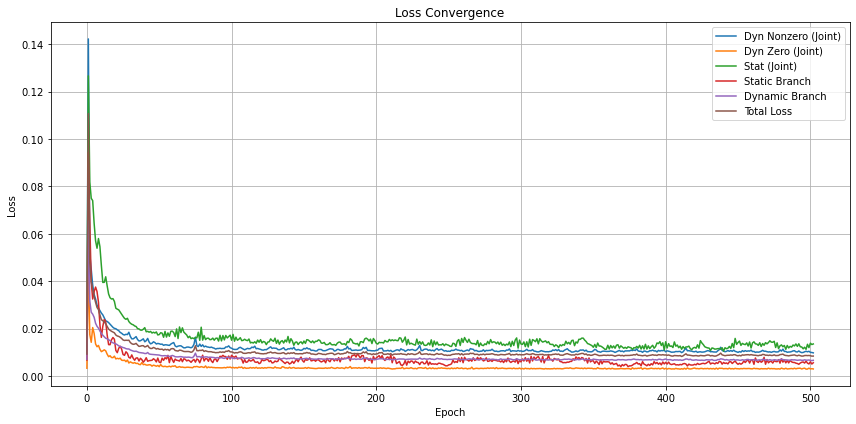

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(loss_log['loss_dyn_nonzero_joint'], label='Dyn Nonzero (Joint)')
plt.plot(loss_log['loss_dyn_zero_joint'], label='Dyn Zero (Joint)')
plt.plot(loss_log['loss_stat_joint'], label='Stat (Joint)')
plt.plot(loss_log['loss_static_branch'], label='Static Branch')
plt.plot(loss_log['loss_dynamic_branch'], label='Dynamic Branch')
plt.plot(loss_log['total_loss'], label='Total Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

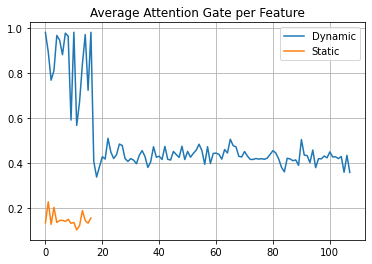

In [52]:
plt.plot(g_dyn.mean(dim=0).detach().cpu().numpy(), label='Dynamic')
plt.plot(g_stat.mean(dim=0).detach().cpu().numpy(), label='Static')
plt.title("Average Attention Gate per Feature")
plt.legend()
plt.grid(True)
plt.show()


## Ploting Loss

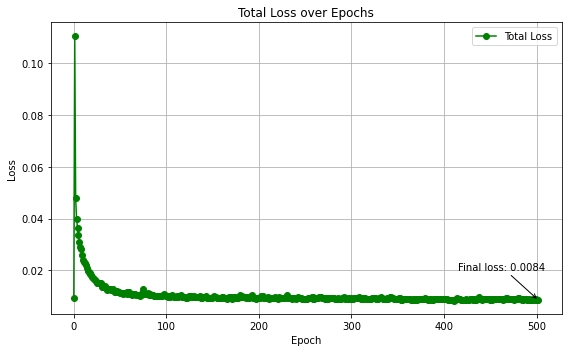

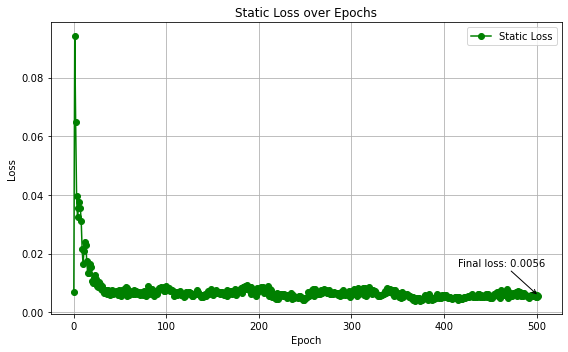

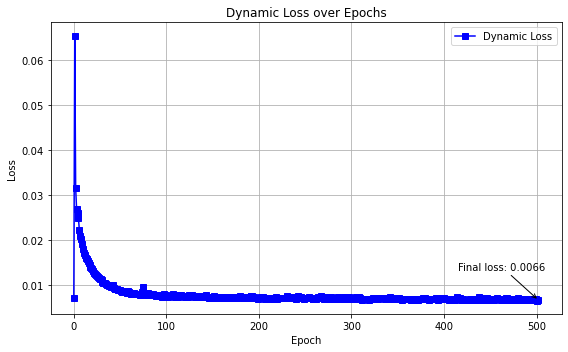

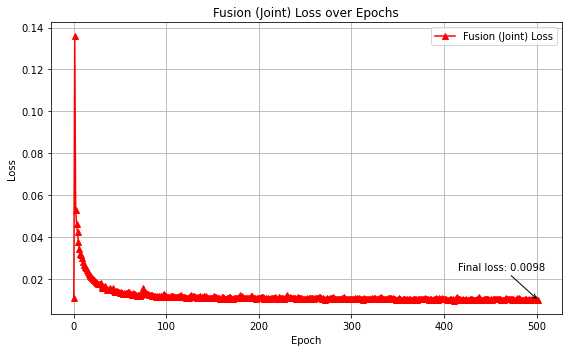

In [53]:
import matplotlib.pyplot as plt

# ----- Plot Total Loss -----
plt.figure(figsize=(8, 5))
plt.plot(loss_total_history, label="Total Loss", color='green', marker='o')
plt.title("Total Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.annotate(f'Final loss: {loss_total_history[-1]:.4f}', 
             xy=(len(loss_total_history)-1, loss_total_history[-1]), 
             xytext=(-80, 30), 
             textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()

# ----- Plot Static Loss -----
plt.figure(figsize=(8, 5))
plt.plot(loss_static_history, label="Static Loss", color='green', marker='o')
plt.title("Static Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.annotate(f'Final loss: {loss_static_history[-1]:.4f}', 
             xy=(len(loss_static_history)-1, loss_static_history[-1]), 
             xytext=(-80, 30), 
             textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()

# ----- Plot Dynamic Loss -----
plt.figure(figsize=(8, 5))
plt.plot(loss_dynamic_history, label="Dynamic Loss", color='blue', marker='s')
plt.title("Dynamic Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.annotate(f'Final loss: {loss_dynamic_history[-1]:.4f}', 
             xy=(len(loss_dynamic_history)-1, loss_dynamic_history[-1]), 
             xytext=(-80, 30), 
             textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()

# ----- Plot Fusion (Joint) Loss -----
plt.figure(figsize=(8, 5))
plt.plot(loss_joint_history, label="Fusion (Joint) Loss", color='red', marker='^')
plt.title("Fusion (Joint) Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.annotate(f'Final loss: {loss_joint_history[-1]:.4f}', 
             xy=(len(loss_joint_history)-1, loss_joint_history[-1]), 
             xytext=(-80, 30), 
             textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()


## Saving embedding

In [54]:
z_fused

tensor([[-0.0704,  0.1799, -0.2806,  ..., -0.1237, -0.0891,  0.0388],
        [-0.0482, -0.0017,  0.0488,  ..., -0.0624,  0.0574,  0.0016],
        [-0.0069, -0.2607,  0.0165,  ..., -0.3136,  0.3083, -0.0228],
        ...,
        [ 0.0585, -0.1675, -0.0826,  ...,  0.1100, -0.0803, -0.1586],
        [ 0.0160, -0.1886,  0.0077,  ...,  0.1721, -0.1359, -0.1516],
        [ 0.0759, -0.1479, -0.0528,  ...,  0.1087, -0.0789, -0.1521]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [55]:
# embeddings = z_fused.cpu().detach().numpy().to(device)  # Convertir a numpy array
embeddings = z_fused.cpu().detach().to(device)  # Convertir a numpy array


In [56]:
embeddings = embeddings.cpu().numpy()
# embeddings = embeddings.numpy()

# embeddings
embeddings

array([[-0.07038267,  0.1799058 , -0.28064975, ..., -0.12373167,
        -0.08911096,  0.03880602],
       [-0.04822262, -0.00165555,  0.0487971 , ..., -0.06239226,
         0.0573699 ,  0.00164344],
       [-0.00693609, -0.26068565,  0.01649634, ..., -0.31363526,
         0.3083378 , -0.022837  ],
       ...,
       [ 0.05852816, -0.16754735, -0.08260482, ...,  0.11000784,
        -0.08033216, -0.15863137],
       [ 0.01595121, -0.18857574,  0.00770144, ...,  0.17206897,
        -0.13590676, -0.15159334],
       [ 0.07588012, -0.14786164, -0.05275796, ...,  0.10871095,
        -0.0788638 , -0.15208481]], dtype=float32)

In [57]:
# Save embeddings in CSV
import pandas as pd
N_LAYERS = 2
ACTIVATION_OPTION = best_params["activation"]
embedding_df = pd.DataFrame(embeddings)

name_file_emb = "node_embeddings_"+TYPE_DATA+"_AutoML-" + str(N_LAYERS) + "_"+ ACTIVATION_OPTION + "_"+ data_set+ "_"+ type_graph_conv +'.csv'

embedding_df.to_csv(f"{output_folder}/"+name_file_emb, index=False)

In [58]:
# # Save the complete model
# torch.save({
#     'model_state_dict': best_model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'params': best_params
# }, f'{output_folder}/best_model_{TYPE_DATA}_{data_set}_{type_graph_conv}.pth')

In [59]:
# Save metadatos (parameters and performance)
metadata = {
    "best_params": best_params,
#     "final_loss": loss_values[-1],
#     "evaluation_metrics": {
#         "zero_accuracy": final_zero_acc,
#         "mae_non_zero": final_mae_non_zero
#                         },
#     "num_features": num_features,
    "loss_func": loss_func,
#     "weight_decay": weightDecay_value
}

with open(f'{output_folder}/model_metadata_{TYPE_DATA}_{data_set}_{type_graph_conv}.json', 'w') as f:
    json.dump(metadata, f, indent=4)

In [60]:
best_params

{'hidden_dim_s': 124,
 'latent_dim_s': 17,
 'hidden_dim_d': 342,
 'latent_dim_d': 108,
 'hidden_dim_f': 398,
 'latent_dim_f': 78,
 'activation': 'relu',
 'lr': 0.0012298944927361477,
 'num_epochs': 503}

## Reading the Fusion model (third model) Embedding

In [61]:
# Load your embeddings CSV

emb_df = pd.read_csv(f"{output_folder}/{name_file_emb}")

## Apply Kmeans on Embeddings

In [63]:
from sklearn.cluster import KMeans

n_clusters = 12

# train K-means 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(emb_df)

In [64]:
clusters

array([4, 1, 7, ..., 0, 0, 0], dtype=int32)

### TSNE

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap.umap_ as umap

print('data_set' ,data_set)

perplexity = 50 

# Drop non-numeric columns (e.g., node IDs or labels if present)
numeric_cols = emb_df.select_dtypes(include=[np.number]).columns
emb_df = emb_df[numeric_cols]
# t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
tsne = TSNE(
        n_components=2,
        perplexity=perplexity,             # más alto para datos grandes
        n_iter=1500,               # más iteraciones
        learning_rate=300,         # o prueba n_samples/12 = 89240/12 ≈ 7437
        method='barnes_hut',       # eficiente para 2D
        random_state=42,
        verbose=1
    )
tsne_result = tsne.fit_transform(emb_df)




data_set real
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 14640 samples in 0.001s...
[t-SNE] Computed neighbors for 14640 samples in 3.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14640
[t-SNE] Computed conditional probabilities for sample 2000 / 14640
[t-SNE] Computed conditional probabilities for sample 3000 / 14640
[t-SNE] Computed conditional probabilities for sample 4000 / 14640
[t-SNE] Computed conditional probabilities for sample 5000 / 14640
[t-SNE] Computed conditional probabilities for sample 6000 / 14640
[t-SNE] Computed conditional probabilities for sample 7000 / 14640
[t-SNE] Computed conditional probabilities for sample 8000 / 14640
[t-SNE] Computed conditional probabilities for sample 9000 / 14640
[t-SNE] Computed conditional probabilities for sample 10000 / 14640
[t-SNE] Computed conditional probabilities for sample 11000 / 14640
[t-SNE] Computed conditional probabilities for sample 12000 / 14640
[t-SNE] Computed conditional probab

In [66]:
tsne_df = pd.DataFrame(tsne_result)

tsne_df.to_csv(f"{output_folder}/tsne_output_{TYPE_DATA}_{suffix}.csv", index=False)

### Coloring tsne output using original cluster IDs

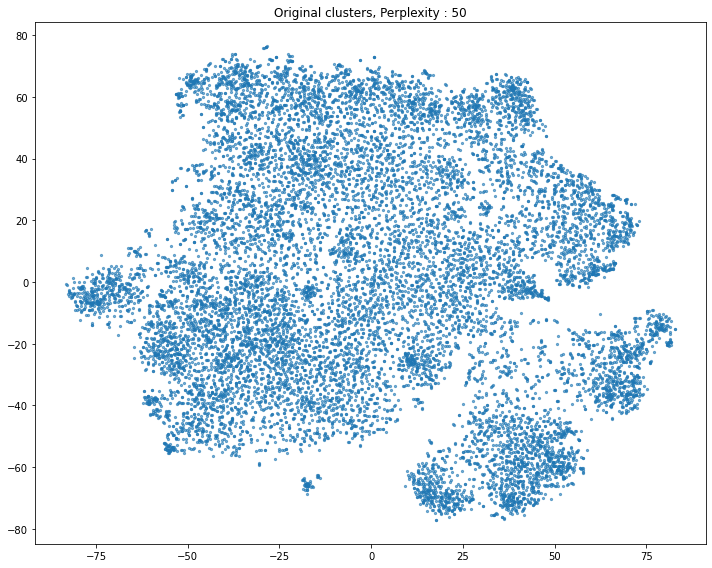

In [67]:
import matplotlib.colors as mcolors

# # Visualization
plt.figure(figsize=(10, 8))
cmap = mcolors.ListedColormap(plt.cm.tab20.colors[8:])
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                      alpha=0.6, s=5)
# plt.colorbar(scatter, label='Cluster ID')
plt.title(f'Original clusters, Perplexity : {perplexity}')
plt.tight_layout()
plt.savefig(f'{output_folder}/tsne_original_Ids_{TYPE_DATA}_{data_set}_{type_graph_conv}.png', dpi=300) 
plt.show()

In [ ]:
# add Kmeans cluster IDs
df_nodes['clusterID_kmeans_'+TYPE_DATA] = clusters


### Coloring tsne output using Kmeans cluster IDs

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                     c=df_nodes['clusterID_kmeans_'+TYPE_DATA], cmap=cmap, alpha=0.6, s=5)

plt.title(f'K-means clusters:{n_clusters}, perplexit: {perplexity}')
plt.tight_layout()
plt.savefig(f'{output_folder}/tsne_kmeans_Ids_{TYPE_DATA}_{data_set}_{type_graph_conv}.png', dpi=300) 
plt.show()

In [ ]:
# Seleccionar las columnas
columns_to_save = ['Nodo', f'clusterID_kmeans_{TYPE_DATA}']
df_selected = df_nodes[columns_to_save]

# Crear nombre de archivo
filename = f'to_dissim_clusterID_kmeans_{TYPE_DATA}_{data_set}_{type_graph_conv}.csv'

# Guardar como CSV
df_selected.to_csv(f"{output_folder}/{filename}", index=False)

print(f'Archivo guardado como: {filename}')



## Locating clusters using kmeans cluster_ids

#### normalize dynamic and static on same scale

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist, pdist
from itertools import combinations
from fastdtw import fastdtw
from multiprocessing import Pool, cpu_count

# # Data type configuration
data_type = "static"   # " dynamic" or static


# Create filename
filepath = f'{output_folder}/{filename}'
print(filepath)

# Open file with columns [Nodo,clusterID_kmeans_] 
df_clusters = pd.read_csv(filepath)
name_column = 'clusterID_kmeans_'+TYPE_DATA

if data_type == "static":
    df_features_clusters = pd.concat([static_dt_norm, df_clusters], axis = 1)
else:
    df_features_clusters = pd.concat([dynamic_dt_norm, df_clusters], axis = 1)


# Removing 'Nodo' column
df_features_clusters = df_features_clusters.drop(columns=['Nodo'])

# Group the DataFrame by 'clusterID' and convert each group to a list
listas_por_cluster = [group.drop( name_column, axis=1).values.tolist() for _, group in df_features_clusters.groupby(name_column)]


# Calculation of distances

In [ ]:
df_features_clusters

In [ ]:

# ===================
# subsampling at 10%
# ===================

import random
sub_listas_por_cluster = []
max_samples = 200  # set your maximum threshold here

for lista in listas_por_cluster:
    n = len(lista)
    muestra_size = min(max_samples, max(1, int(0.05 * n)))  # limit the sample size
    muestra = random.sample(lista, muestra_size) if n >= muestra_size else lista.copy()
    sub_listas_por_cluster.append(muestra)

for idx, sublista in enumerate(sub_listas_por_cluster):
    print(f"Cluster {idx}: {len(sublista)} samples")

# ===================
# DISTANCE FUNCTIONS
# ===================
def average_intra_cluster_distance(X_cluster, data_type='static'):
    n = len(X_cluster)
    if n <= 1:
        return 0.0
    if data_type == 'static':
        return np.mean(pdist(X_cluster, 'euclidean'))
    elif data_type == 'dynamic':
        distances = []
        for i in range(n):
            for j in range(i + 1, n):
                dist, _ = fastdtw(X_cluster[i], X_cluster[j])
                distances.append(dist)
        return np.mean(distances)
    else:
        raise ValueError("data_type must be either 'static' or 'dynamic'")

def minimum_inter_cluster_distance(X_cluster_i, X_cluster_j, data_type='static'):
    if len(X_cluster_i) == 0 or len(X_cluster_j) == 0:
        return np.inf
    if data_type == 'static':
        dist_matrix = cdist(X_cluster_i, X_cluster_j, 'euclidean')
    elif data_type == 'dynamic':
        dist_matrix = np.zeros((len(X_cluster_i), len(X_cluster_j)))
        for i in range(len(X_cluster_i)):
            for j in range(len(X_cluster_j)):
                dist, _ = fastdtw(X_cluster_i[i], X_cluster_j[j])
                dist_matrix[i, j] = dist
    else:
        raise ValueError("data_type must be either 'static' or 'dynamic'")
    return np.min(dist_matrix)

def compute_cluster_dissimilarity2(a_i, a_j, b_ij):
    denom1 = np.maximum(a_i, b_ij)
    term1 = np.divide(b_ij - a_i, denom1, out=np.zeros_like(np.array([b_ij])), where=(denom1 != 0))
    denom2 = np.maximum(a_j, b_ij)
    term2 = np.divide(b_ij - a_j, denom2, out=np.zeros_like(np.array([b_ij])), where=(denom2 != 0))
    return 0.5 * (term1 + term2)

def compute_pair_dissimilarity(args):
    i, j, clusters, data_type = args
    a_i = average_intra_cluster_distance(clusters[i], data_type)
    a_j = average_intra_cluster_distance(clusters[j], data_type)
    b_ij = minimum_inter_cluster_distance(clusters[i], clusters[j], data_type)
    S_ij = compute_cluster_dissimilarity2(a_i, a_j, b_ij)
    return (i, j, S_ij)

def compute_all_cluster_dissimilarities(clusters, data_type='static'):
    n = len(clusters)
    S = np.zeros((n, n))

    args_list = [(i, j, clusters, data_type) for i, j in combinations(range(n), 2)]

    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_pair_dissimilarity, args_list)

    for i, j, S_ij in results:
        S[i, j] = S[j, i] = S_ij

    print("Matriz de disimilitudes:\n", S)
    return S

# ===================
# Execution
# ===================

time_start = datetime.now()
print('time_start', time_start.strftime("%H:%M:%S"), 'para', data_type)

if data_type == "static":
    D = compute_all_cluster_dissimilarities(listas_por_cluster, data_type=data_type)
else: # cross clustering option
    D = compute_all_cluster_dissimilarities(sub_listas_por_cluster, data_type=data_type)
    
time_end = datetime.now()
print(time_start.strftime("%H:%M:%S"), '-', time_end.strftime("%H:%M:%S"))

elapsed_time = (time_end - time_start).total_seconds()
print('Elapsed time:', str(elapsed_time), 'seconds')


In [ ]:
df = pd.DataFrame(D)
df.to_csv(f'{output_folder}/cluster_dissimilarities_matrix_{TYPE_DATA}_{data_set}_{data_type}_{type_graph_conv}.csv', index=False)


print(f'Final result: cluster_dissimilarities_matrix_{TYPE_DATA}_{data_set}_{data_type}_{type_graph_conv}.csv')